In [39]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

from typing import Callable, Iterator, Sequence
import functools

import numpy as np
import scipy as sp
import matplotlib.pylab as plt

import jax.numpy as jnp
import jax.scipy as jsp
import jax
import optax
import haiku as hk
import chex
import tqdm

import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
import torch.optim as optim
from tqdm import tqdm
import time


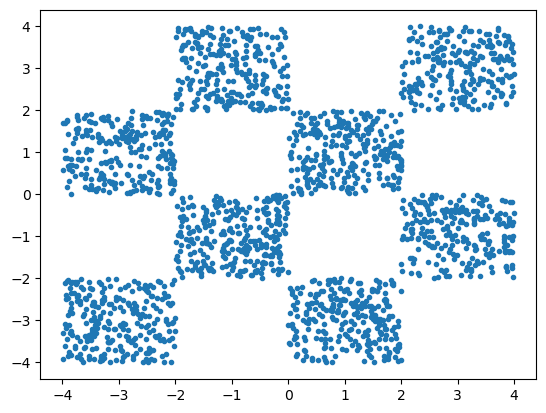

In [35]:
def generate_checkerboard(*, num: int, rng: np.random.Generator) -> np.ndarray:
    # https://github.com/malbergo/stochastic-interpolants/blob/main/notebooks/checker-mirror.ipynb
    x1 = rng.uniform(size=num) * 4 - 2
    x2_ = rng.uniform(size=num) - rng.choice([0, 1], size=(num,)) * 2
    x2 = x2_ + (np.floor(x1) % 2)
    x = np.hstack([x1[:, None], x2[:, None]]) * 2
    return x

X_train = generate_checkerboard(num=2000, rng=np.random.default_rng())
plt.plot(X_train[:, 0], X_train[:, 1], '.')

In [36]:
class DDPM(nn.Module):
    def __init__(self):
        super(DDPM, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )
    
    def forward(self, x):
        return self.net(x)

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DDPM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

# 假设 X_data 是一个已经在内存中的Tensor
X_data = torch.from_numpy(X_train).float().to(device)

n_epochs = 75
epoch_loss_list = []
total_start = time.time()

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    optimizer.zero_grad()

    with autocast(enabled=True):
        predictions = model(X_data)
        loss = F.mse_loss(predictions, X_data)

    scaler = GradScaler()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    scheduler.step()

    epoch_loss += loss.item()
    epoch_loss_list.append(epoch_loss)
    print(f'Epoch {epoch}: Loss = {epoch_loss}')


total_time = time.time() - total_start
print(f"Training completed in {total_time:.2f} seconds.")
torch.save(model.state_dict(), 'model_state_dict.pth')


Epoch 0: Loss = 5.102327823638916
Epoch 1: Loss = 3.75787615776062
Epoch 2: Loss = 2.7752819061279297
Epoch 3: Loss = 1.9050865173339844
Epoch 4: Loss = 1.2582145929336548
Epoch 5: Loss = 0.7634896039962769
Epoch 6: Loss = 0.5067915916442871
Epoch 7: Loss = 0.44705671072006226
Epoch 8: Loss = 0.5062065124511719
Epoch 9: Loss = 0.6303237676620483
Epoch 10: Loss = 0.7595940828323364
Epoch 11: Loss = 0.7390145659446716
Epoch 12: Loss = 0.7154445648193359
Epoch 13: Loss = 0.6312129497528076
Epoch 14: Loss = 0.5118687748908997
Epoch 15: Loss = 0.41482195258140564
Epoch 16: Loss = 0.32374998927116394
Epoch 17: Loss = 0.3111046254634857
Epoch 18: Loss = 0.2925235629081726
Epoch 19: Loss = 0.3207526206970215
Epoch 20: Loss = 0.3506779074668884
Epoch 21: Loss = 0.36463645100593567
Epoch 22: Loss = 0.3899410367012024
Epoch 23: Loss = 0.39502546191215515
Epoch 24: Loss = 0.3897603750228882
Epoch 25: Loss = 0.37128907442092896
Epoch 26: Loss = 0.3594995439052582
Epoch 27: Loss = 0.3377068042755127

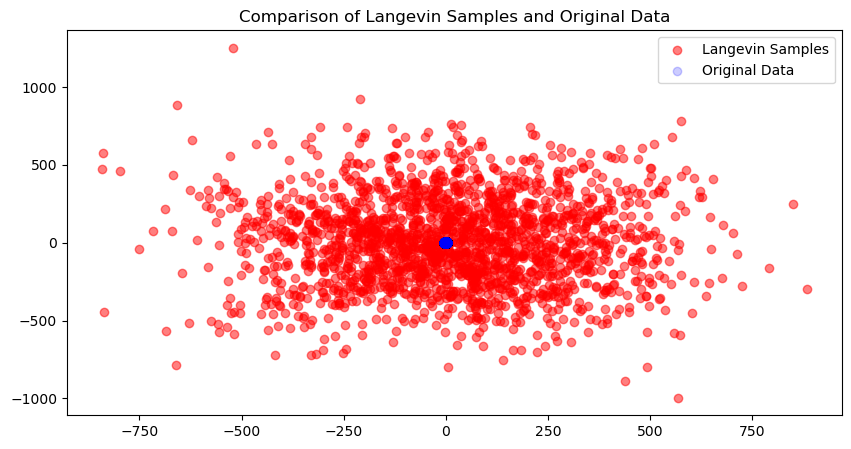

In [46]:
def langevin_sampling(model, initial_samples, step_size, num_steps, device):
    samples = initial_samples.to(device)
    for _ in range(num_steps):
        noise = torch.randn_like(samples)
        samples_grad = model(samples)
        samples = samples + step_size * samples_grad + torch.sqrt(torch.tensor(2.0 * step_size)) * noise
    return samples

# 初始化模型和设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('model_state_dict.pth'))

# 初始化采样
initial_samples = 2 * torch.randn(2000, 2)  # 假设初始样本正态分布
step_size = 5e-3
num_steps = 1000

# 进行 Langevin 采样
samples = langevin_sampling(model, initial_samples, step_size, num_steps, device)

# 将 NumPy 数据转换为 PyTorch Tensor
X_data = torch.from_numpy(X_train).float().to(device)

# 可视化原始数据和采样结果
plt.figure(figsize=(10, 5))
plt.scatter(samples.cpu().detach().numpy()[:, 0], samples.cpu().detach().numpy()[:, 1], color='red', alpha=0.5, label='Langevin Samples')
plt.scatter(X_data.cpu().numpy()[:, 0], X_data.cpu().numpy()[:, 1], color='blue', alpha=0.2, label='Original Data')
plt.title('Comparison of Langevin Samples and Original Data')
plt.legend()
plt.show()
